# CNN model to detect anc localise sources

## Collect source and background datasets

In [1]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile

# info tables
src_info = f'/data01/homes/dipiano/E4/z60_NLST/crab/sim/merged_data.dat'
bkg_info = f'/data01/homes/dipiano/E4/z60_NLST/background/sim/merged_data.dat'

# dataset 
filename = '/data01/homes/dipiano/E4/z60_NLST/datasets_50s_1000src_1000bkg.npy'
ds = np.load(filename, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
print(f"Classes: {ds.keys()}\n")
print(f"\nSRC dataset size: {len(ds['SRC'])}")
print(f"BKG dataset size: {len(ds['BKG'])}")

Classes: dict_keys(['SRC', 'BKG'])


SRC dataset size: 1000
BKG dataset size: 1000


### Split train and test datasets

In [3]:
from astroai.tools.utils import split_dataset

train_data, train_labels, test_data, test_labels = split_dataset(ds, split=80, reshape=True, binning=250)

print(f"Train dataset: {len(train_data)}, {train_data.shape}")
print(f"Train labels: {len(train_labels)}, {train_labels.shape}")
print(f"\nTest dataset: {len(test_data)}, {test_data.shape}")
print(f"Test labels: {len(test_labels)}, {test_labels.shape}")

norm min: 0.0
norm max: 0.6525847536869076
Train dataset: 1600, (1600, 250, 250, 1)
Train labels: 1600, (1600, 1)

Test dataset: 400, (400, 250, 250, 1)
Test labels: 400, (400, 1)


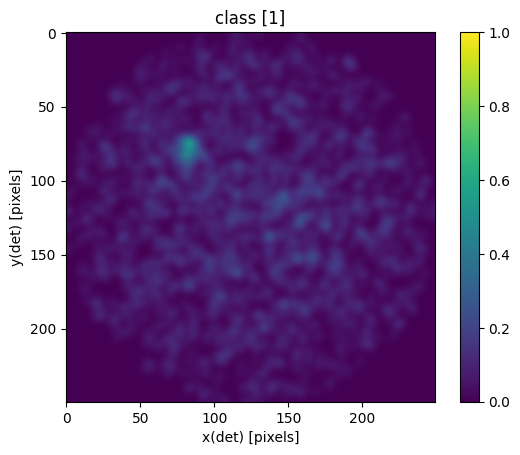

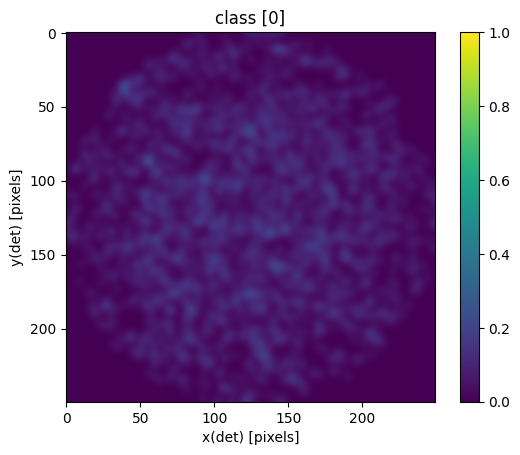

In [15]:
from astroai.tools.utils import plot_heatmap

plot_heatmap(train_data[0], title=f'class {train_labels[0]}', show=True, save=False, save_name=None)
plot_heatmap(train_data[-1], title=f'class {train_labels[-1]}', show=True, save=False, save_name=None)

## Load TensorBoard

In [4]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

## Create CNN Model

In [5]:
import tensorflow as tf
TF_CPP_MIN_LOG_LEVEL="1"

# seed
tf.random.set_seed(42)
np.random.seed(42)

# create TF dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

# create model
model = tf.keras.models.Sequential()
model.add(layers.Conv2D(2, (5, 5), activation='relu', input_shape=(250, 250, 1), name='conv2d_1'))
model.add(layers.MaxPooling2D((2, 2), name='maxpool2d_1'))
model.add(layers.Conv2D(2, (5, 5), activation='relu', name='conv2d_2'))
model.add(layers.MaxPooling2D((2, 2), name='maxpool2d_2'))
model.add(layers.Conv2D(2, (5, 5), activation='relu', name='conv2d_3'))
#model.add(tf.keras.layers.Dropout(0.2), name='drop_1')
model.add(tf.keras.layers.Flatten(), name='flat_1')
model.add(tf.keras.layers.Dense(10, activation='relu', name='dense_1'))
#model.add(tf.keras.layers.Dropout(0.2, name='drop_2'))
model.add(tf.keras.layers.Dense(2, activation='sigmoid', name='dense_2'))

model.summary()

2023-10-26 10:42:54.075947: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-26 10:42:54.250785: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-26 10:42:54.250815: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-26 10:42:54.959190: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 246, 246, 2)       52        
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 123, 123, 2)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 119, 119, 2)       102       
                                                                 
 maxpool2d_2 (MaxPooling2D)  (None, 59, 59, 2)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 55, 55, 2)         102       
                                                                 
 dropout (Dropout)           (None, 55, 55, 2)         0         
                                                                 
Total params: 256
Trainable params: 256
Non-trainable pa

### TensorBoard callback

In [7]:
from datetime import datetime
logdir = join("logs", "cnn-v01-detect" + datetime.now().strftime("%Y%m%dT%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

### Compile the model

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
              loss=tf.keras.losses.sparse_categorical_crossentropy, 
              #loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

### Load tensorboard

In [12]:
%tensorboard --logdir logs --port 6006

Reusing TensorBoard on port 6006 (pid 17021), started 0:02:37 ago. (Use '!kill 17021' to kill it.)

### Train the model

In [13]:
# when not specified batch_size = 32
history = model.fit(x=train_data, y=train_labels, batch_size=50, epochs=100, validation_data=(test_data, test_labels), 
          callbacks=[tensorboard_callback], shuffle=True)

Epoch 1/100
8/8 [==============================] - 8s 897ms/step - loss: 0.6941 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/100
8/8 [==============================] - 7s 813ms/step - loss: 0.6932 - accuracy: 0.4988 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/100
8/8 [==============================] - 7s 824ms/step - loss: 0.6932 - accuracy: 0.5050 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/100
8/8 [==============================] - 7s 882ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/100
8/8 [==============================] - 7s 863ms/step - loss: 0.6932 - accuracy: 0.4938 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/100
8/8 [==============================] - 7s 856ms/step - loss: 0.6931 - accuracy: 0.4944 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/100
8/8 [==============================] - 7s 863ms/step - loss: 0.6932 - accuracy: 0.4800 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 8/100
8

Epoch 59/100
8/8 [==============================] - 7s 845ms/step - loss: 0.6931 - accuracy: 0.5088 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 60/100
8/8 [==============================] - 7s 844ms/step - loss: 0.6931 - accuracy: 0.5050 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 61/100
8/8 [==============================] - 7s 839ms/step - loss: 0.6931 - accuracy: 0.4963 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 62/100
8/8 [==============================] - 6s 797ms/step - loss: 0.6932 - accuracy: 0.4931 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 63/100
8/8 [==============================] - 6s 797ms/step - loss: 0.6932 - accuracy: 0.4656 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 64/100
8/8 [==============================] - 7s 816ms/step - loss: 0.6931 - accuracy: 0.5081 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 65/100
8/8 [==============================] - 7s 829ms/step - loss: 0.6932 - accuracy: 0.4975 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 

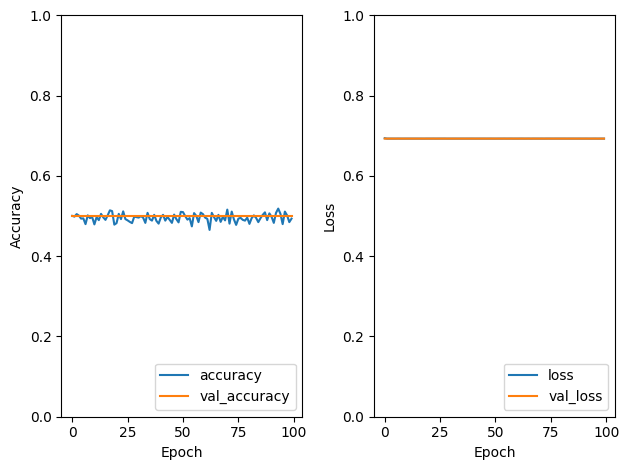

13/13 - 0s - loss: 0.6931 - accuracy: 0.5000 - 348ms/epoch - 27ms/step


In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2)
ax[0].plot(history.history['accuracy'], label='accuracy')
ax[0].plot(history.history['val_accuracy'], label = 'val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim([0,1])
ax[0].legend(loc='lower right')

ax[1].plot(history.history['loss'], label='loss')
ax[1].plot(history.history['val_loss'], label = 'val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_ylim([0,1])
ax[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

test_loss, test_acc = model.evaluate(test_data,  test_labels, verbose=2)